In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np



In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = pd.read_csv('data/training/train.csv')

In [5]:

from sklearn.model_selection import train_test_split

#train, test = train_test_split(data, test_size=0.5, random_state=1337)

train, valid = train_test_split(data, test_size=0.1, random_state=1337)

print(len(train), len(valid))
train.head()

# undersampling
from sklearn.utils import resample

# Separate the data into two DataFrames based on the label
label_0 = train[train['LABEL'] == 0]
label_1 = train[train['LABEL'] == 1]

# Determine the size of the smaller class (label 1)
min_class_size = min(len(label_0), len(label_1))

# Undersample the majority class (label 0) to make the classes 1:1
label_0_undersampled = resample(label_0, replace=False, n_samples=(25000), random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_data = pd.concat([label_0_undersampled, label_1])

# Shuffle the data to mix the classes
train = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)


65360 7263


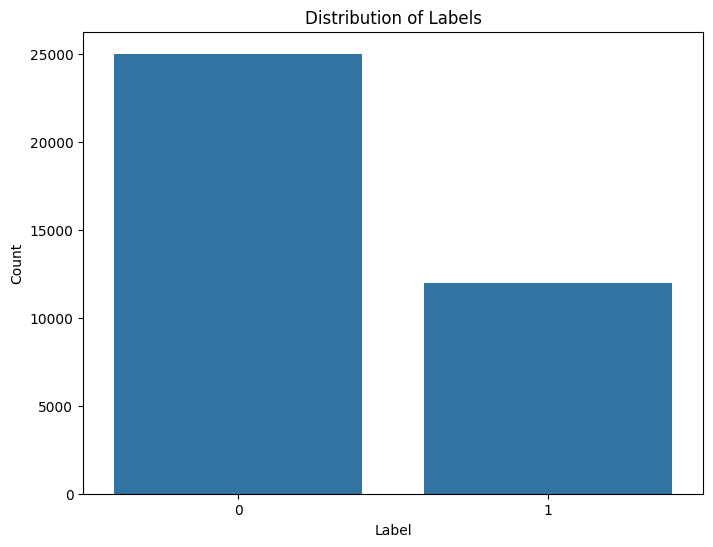

In [6]:
import seaborn as sns

# Plot the distribution of labels using a countplot
plt.figure(figsize=(8, 6))
sns.countplot(x='LABEL', data=train)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()



In [7]:
import torchtext
from torchtext.data import get_tokenizer
from collections import Counter

tokenizer = get_tokenizer("basic_english")
""" todo try with other tokenizer (not basic_english)"""

# Build vocabulary
words=[]
num_words = 3000

for text in train['TEXT']:
    if pd.isna(text):
        continue
    tokens=tokenizer(text)
    words.extend(tokens)

top_3k = dict(Counter(words).most_common(3000)) #3000
vocab = torchtext.vocab.vocab(top_3k, specials = ['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>']) #default index used when an unknown words is found

print(train['TEXT'].iloc[1])
print(vocab.forward(tokenizer(train['TEXT'].iloc[1]))) #example of how a sentence is transformed into a sequence of numerical IDs

Hopefully we've all got exciting ideas now .
[850, 9, 5, 94, 67, 116, 1336, 280, 107, 2]


[0, 777, 6434, 2757, 2510, 1983, 1691, 1447, 1208, 1055, 918, 711, 595, 475, 390, 319, 265, 231, 207, 165, 132, 116, 90, 92, 81, 59, 52, 42, 41, 26, 25, 16, 14, 13, 7, 11, 5, 7, 4, 3, 4, 8, 1, 4, 3, 0, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 5, 74, 129, 279, 409, 557, 725, 775, 801, 828, 761, 731, 665, 585, 563, 499, 472, 390, 346, 301, 282, 230, 194, 167, 157, 158, 118, 100, 92, 96, 73, 61, 43, 39, 40, 30, 31, 18, 20, 27, 19, 8, 14, 11, 8, 6, 4, 6, 4, 4, 3, 1, 2, 0, 4, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]


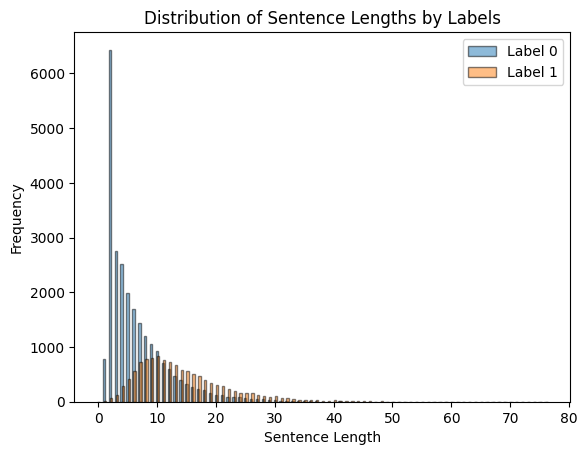

In [8]:
label_1_len = [0] * 77
label_0_len = [0] * 77

for row in train.iterrows():
    text = row[1]["TEXT"]
    label = row[1]["LABEL"]

    if label == 1:
        if pd.isna(text):
            label_1_len[0] += 1
        else:
            label_1_len[len(text.split())] += 1
    else:
        if pd.isna(text):
            label_0_len[0] += 1
        else:
            label_0_len[len(text.split())] += 1

print(label_0_len)
print(label_1_len)

# Setting the x-axis positions for the bars
x_positions = list(range(len(label_0_len)))

# Plotting side-by-side bar plots for both labels
plt.bar(x_positions, label_0_len, width=0.4, edgecolor='black', alpha=0.5, label='Label 0')
plt.bar(x_positions, label_1_len, width=0.4, edgecolor='black', alpha=0.5, label='Label 1', align='edge')

plt.title('Distribution of Sentence Lengths by Labels')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()




In [9]:
max_len=25

def vectorize_sentences(texts, max_len):
    vectors=[]
    for text in texts:
        if not pd.isna(text):
            tokens=tokenizer(text)
            v=vocab.forward(tokens)
        else:
            v = []
        if len(v) > max_len : v = v[:max_len]
        if len(v) < max_len : #padding
            tmp = np.full(max_len, vocab['<pad>'])
            tmp[0:len(v)]=v 
            v = tmp
        vectors.append(np.array(v))
    return np.array(vectors)


train_X = vectorize_sentences(train['TEXT'], max_len)
val_X = vectorize_sentences(valid['TEXT'], max_len)

train_y = np.array(train['LABEL']).reshape(-1,1)
val_y = np.array(valid['LABEL']).reshape(-1,1)


In [10]:
# define batch size
batch_size = 50

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).float().to(device))
validset = TensorDataset(torch.from_numpy(val_X).to(device), torch.from_numpy(val_y).float().to(device))

# create dataloaders
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(validset, shuffle=True, batch_size=batch_size)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vectors


class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        """
        vocab_size: (int) size of the vocabulary - required by embeddings
        embed_dim: (int) size of embeddings
        hidden_dim: (int) number of hidden units
        num_class: (int) number of classes
        """
        super().__init__()
        self.hidden_dim=hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)
        self.dropout = nn.Dropout(0.2)


    def forward(self, text):
        r"""
        Arguments:
            text: 1-D tensor representing a bag of text tensors
        """
        text=self.embedding(text)
        output, (hidden, cell) = self.lstm(text)
        x = hidden.view(-1, self.hidden_dim)
        x=self.dropout(x)
        x=self.fc(x)
        out = torch.sigmoid(x)
        return out
    
    def get_embedding_for(self, w):
        idx = vocab.lookup_indices([w])
        return self.embedding(torch.Tensor(idx).int())
    


In [12]:
input_dim = num_words + 2 #add 2 for <unk> and <pad> symbols
embedding_dim = 300
hidden_dim = 100
output_dim = 1

# Instantiate model class and assign to object
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim)

# Push model to CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [13]:
# Number of groups of parameters
print('Number of groups of parameters {}'.format(len(list(model.parameters()))))
print('-'*50)
# Print parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
print('-'*50)

Number of groups of parameters 7
--------------------------------------------------
torch.Size([3002, 300])
torch.Size([400, 300])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([1, 100])
torch.Size([1])
--------------------------------------------------


In [14]:
from sklearn.metrics import f1_score
def train_model(model, optizmizer, loss_criterion):
    iter = 0
    num_epochs = 10
    history_train_acc, history_val_acc, history_train_loss, history_val_loss, history_train_f1, history_val_f1,  = [], [], [], [], [], []
    best_f1_score = 0
    for epoch in range(num_epochs):
        for i, (samples, labels) in enumerate(train_loader):
            # Training mode
            model.train()

            # Load samples
            samples = samples.view(-1, max_len).to(device)
            labels = labels.view(-1, 1).to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(samples)

            # Calculate Loss: softmax --> cross entropy loss
            loss = loss_criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1

            if iter % 100 == 0:
                # Get training statistics
                train_loss = loss.data.item()

                # Testing mode
                model.eval()

                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for samples, labels in valid_loader:
                    # Load samples
                    samples = samples.view(-1, max_len).to(device)
                    labels = labels.view(-1).to(device)

                    # Forward pass only to get logits/output
                    outputs = model(samples)

                    # Val loss
                    val_loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))

                    predicted = outputs.ge(0.5).view(-1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum().item()
                    # correct = (predicted == labels.byte()).int().sum().item()

                accuracy = 100. * correct / total


                # Get training statistics
                train_loss = loss.data.item()


                # Calculate F1 score
                with torch.no_grad():
                    all_predicted = []
                    all_labels = []

                    for samples, labels in valid_loader:
                        # Load samples
                        samples = samples.view(-1, max_len).to(device)
                        labels = labels.view(-1).to(device)

                        # Forward pass only to get logits/output
                        outputs = model(samples)

                        # Calculate F1 score
                        predicted = (outputs >= 0.5).int()
                        all_predicted.extend(predicted.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())

                    val_f1 = f1_score(all_labels, all_predicted)

                print('Iter: {} | Train Loss: {} | Val Loss: {} | Val Accuracy: {} | Val F1 Score: {}'.format(iter, train_loss, val_loss.item(), round(accuracy, 2), val_f1))

                # Append to history
                history_val_loss.append(val_loss.data.item())
                history_val_acc.append(round(accuracy, 2))
                history_train_loss.append(train_loss)
                history_val_f1.append(val_f1)

                # Save model when F1 score beats best F1 score
                if val_f1 > best_f1_score:
                    best_f1_score = val_f1
                    # We can load this best model on the validation set later
                    torch.save(model.state_dict(), 'best_model.pth')

                        
    print("max val f1 = ", max(history_val_f1))
    return (history_train_acc, history_val_acc, history_train_loss, history_val_loss,  history_train_f1, history_val_f1)


In [15]:
def plot_losses(history_train_loss, history_val_loss):
    plt.style.use('bmh')
    plt.rc('axes', facecolor='none')
    plt.rc('figure', figsize=(16, 4))

    # Plotting loss graph
    plt.plot(history_train_loss, label='Train')
    plt.plot(history_val_loss, label='Validation')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

In [16]:

def look_parameters(mdl):
    weights = torch.Tensor().to(device)
    for param_group in list(mdl.parameters()):
        weights = torch.cat((param_group.view(-1), weights))
    ws = weights.detach().cpu().numpy()
    plt.hist(ws.reshape(-1), range=(-.5, .5), bins=501)


In [17]:
# Instantiate model class and assign to object
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim)
model.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=0.001)


(train_acc, val_acc, train_loss, val_loss, history_train_f1, history_val_f1) = train_model(model, optimizer, criterion)


Iter: 100 | Train Loss: 0.509215772151947 | Val Loss: 0.3163234293460846 | Val Accuracy: 80.24 | Val F1 Score: 0.5448778940691404
Iter: 200 | Train Loss: 0.4028046429157257 | Val Loss: 0.4737056493759155 | Val Accuracy: 77.61 | Val F1 Score: 0.5626681011296395
Iter: 300 | Train Loss: 0.49098721146583557 | Val Loss: 0.09898977726697922 | Val Accuracy: 76.72 | Val F1 Score: 0.5606651078202131
Iter: 400 | Train Loss: 0.5095152258872986 | Val Loss: 0.32119351625442505 | Val Accuracy: 77.34 | Val F1 Score: 0.5620010643959553
Iter: 500 | Train Loss: 0.27568063139915466 | Val Loss: 0.20227807760238647 | Val Accuracy: 82.05 | Val F1 Score: 0.5295815295815295
Iter: 600 | Train Loss: 0.5075446963310242 | Val Loss: 0.15111884474754333 | Val Accuracy: 83.08 | Val F1 Score: 0.48033826638477795
Iter: 700 | Train Loss: 0.5397014021873474 | Val Loss: 0.40816372632980347 | Val Accuracy: 77.81 | Val F1 Score: 0.5668995163890381
Iter: 800 | Train Loss: 0.4945867657661438 | Val Loss: 0.25494468212127686 |

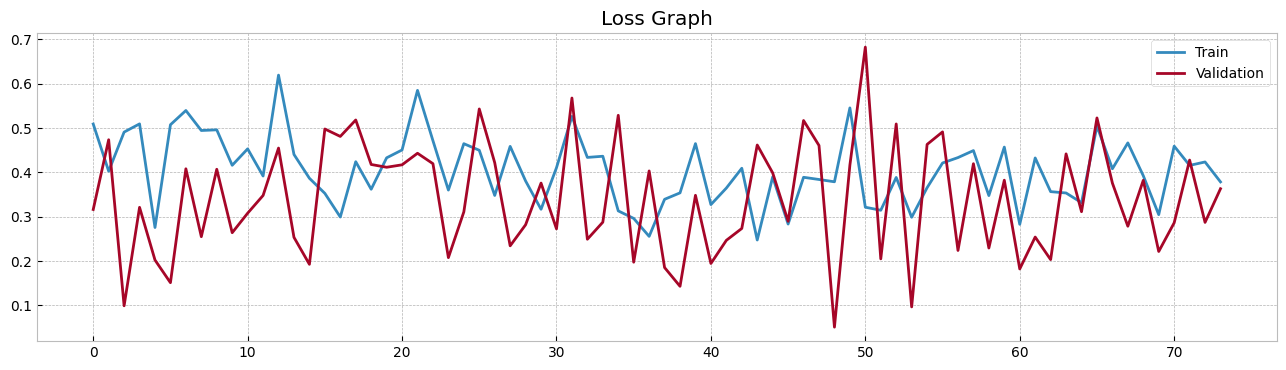

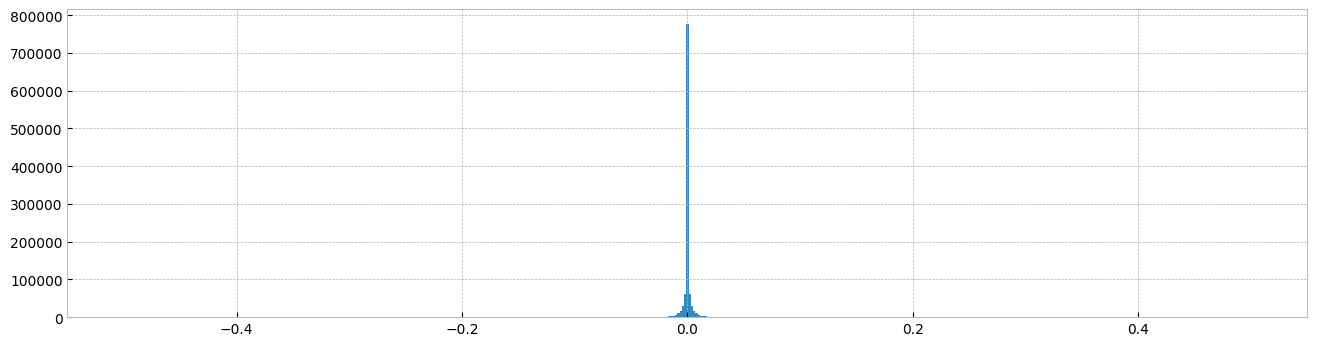

In [18]:
plot_losses(train_loss, val_loss)
look_parameters(model)

In [19]:
# Load the trained model state
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Assuming 'input_data' is your new data
input_data = pd.read_csv('data/test/test.csv')

# Vectorize the input data
input_X = vectorize_sentences(input_data['TEXT'], max_len)

# Convert to PyTorch tensor and move to the same device as your model
input_X_tensor = torch.from_numpy(input_X).to(device)

# Perform Prediction
with torch.no_grad():
    model_outputs = model(input_X_tensor)

# Assuming you're using a binary classification threshold of 0.5
predictions = (model_outputs >= 0.5).cpu().numpy().astype(int)
predictions = predictions.astype(int)
# Convert predictions to a DataFrame
predictions_df = pd.DataFrame({'y_pred': predictions.flatten()})

print(predictions_df)
# Concatenate predictions with the input_data DataFrame
result_df = pd.concat([input_data, predictions_df], axis=1)
result_df = result_df.drop(['SPEAKER', 'TEXT'], axis=1)

# Fill NaN values in the 'LABEL' column with 0.0
result_df['y_pred'] = result_df['y_pred'].fillna(0.0)

# Replace 1.0 with 1 and 0.0 with 0
result_df['y_pred'] = result_df['y_pred'].replace({1.0: 1, 0.0: 0}).astype(int)

import tools.make_submission

tools.make_submission.make_submission_from_df(result_df,"../predictions/lstm.csv")


       y_pred
0           0
1           0
2           0
3           0
4           0
...       ...
31021       0
31022       0
31023       0
31024       1
31025       0

[31026 rows x 1 columns]
